# Vertical access combined optimization

In [1]:
from simsopt._core import load
from simsopt.geo import SurfaceRZFourier
from simsopt.geo import VerticalPortDiscrete

import matplotlib.pyplot as plt 
import numpy as np
import jax.numpy as jnp
from jax import vjp, jvp, jacfwd


from simsopt.geo import CurveCWSFourierFree
from simsopt.geo import Curve2D
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

%matplotlib widget

In [2]:
# Load the surface, assumed fixed in this notebook. 
surf = SurfaceRZFourier.from_vmec_input( 'input.scaled', range="full torus" )

nfp = surf.nfp
qpts_phi = np.linspace(0, 1/(2*nfp), 8)
qpts_theta = np.linspace(0, 1, 32)

vessel = SurfaceRZFourier(
    nfp = surf.nfp,
    mpol = surf.mpol,
    ntor = surf.ntor,
    stellsym = surf.stellsym,
    quadpoints_phi=qpts_phi,
    quadpoints_theta=qpts_theta,
    dofs = surf.dofs
)
s = surf
v = SurfaceRZFourier( nfp=s.nfp, stellsym=True, mpol=1, ntor=1, quadpoints_phi=qpts_phi, quadpoints_theta=qpts_theta )
v.set('rc(0,0)', s.get('rc(0,0)'))
R1 = 0.5
v.set('rc(1,0)', 0.8*R1 )
v.set('zs(1,0)', 0.8*R1 )
v.fix_all()
v.unfix('rc(0,0)')


vessel.fix_all()
vessel.unfix('rc(0,0)')
vessel.unfix('rc(1,0)')
vessel.unfix('rc(2,-1)')
vessel.unfix('zs(1,1)')

bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]
#curves = [c.curve for c in bs.coils[-ncoils:]]

<Axes3D: >

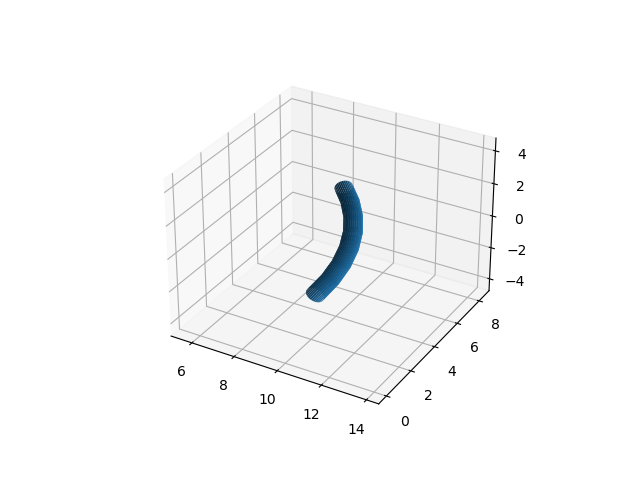

In [3]:
v.plot(show=False,close=True)

In [21]:
order = 2
qpts = np.linspace(0,1,24)
curve2d = Curve2D(
    qpts,
    order
)

curve2d.set('phic(0)', 0.0625)
curve2d.set('phic(1)', 0.025)
curve2d.set('thetac(0)', 0.3)
curve2d.set('thetas(1)', 0.25)

In [22]:
curve2d.gamma().shape

(24, 3)

In [23]:
curve2d.gammadash().shape

(24, 3)

In [24]:
cws = CurveCWSFourierFree( curve2d, v )

In [25]:
test_gd = cws.gammadash()
g = cws.gamma()
gdash2 = test_gd

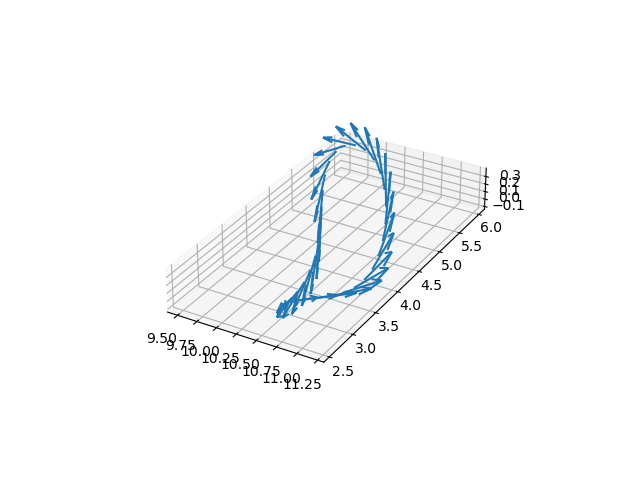

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.quiver(g[:,0], g[:,1], g[:,2], gdash2[:,0], gdash2[:,1], gdash2[:,2], length=.1)
ax.set_aspect('equal')

# Test modified penalties

In [17]:
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

### ProjectedEnclosedArea

In [18]:
Jxyarea = ProjectedEnclosedArea( cws, projection='zphi' )

In [19]:
Jxyarea.J()

Array(-1.41967465, dtype=float64)

In [20]:
gamma = cws.gamma()
gammadash = cws.gammadash()
v = Jxyarea.thisgrad0(gamma, gammadash)
dg = cws.dgamma_by_dcurve_vjp(v)
cws.curve.dgamma_by_dcoeff_vjp(dg)

In [21]:
Jxyarea.dJ()

array([ 6.07695535e+01, -7.06244348e+01,  1.25796787e+02,  5.91152886e+01,
       -2.11578240e+02, -1.67955570e+01,  4.43448074e+00, -5.97243632e+00,
        7.17770779e+00, -1.09616549e+01, -1.36113782e-01,  1.91955329e-01,
       -1.08968573e-01,  2.89662612e+00])

In [22]:
Jxyarea.dof_names

['Curve2D1:phic(0)',
 'Curve2D1:phic(1)',
 'Curve2D1:phic(2)',
 'Curve2D1:phis(1)',
 'Curve2D1:phis(2)',
 'Curve2D1:thetac(0)',
 'Curve2D1:thetac(1)',
 'Curve2D1:thetac(2)',
 'Curve2D1:thetas(1)',
 'Curve2D1:thetas(2)',
 'SurfaceRZFourier2:rc(0,0)',
 'SurfaceRZFourier2:rc(1,0)',
 'SurfaceRZFourier2:rc(2,-1)',
 'SurfaceRZFourier2:zs(1,1)']

Text(0.5, 0, '$\\epsilon$')

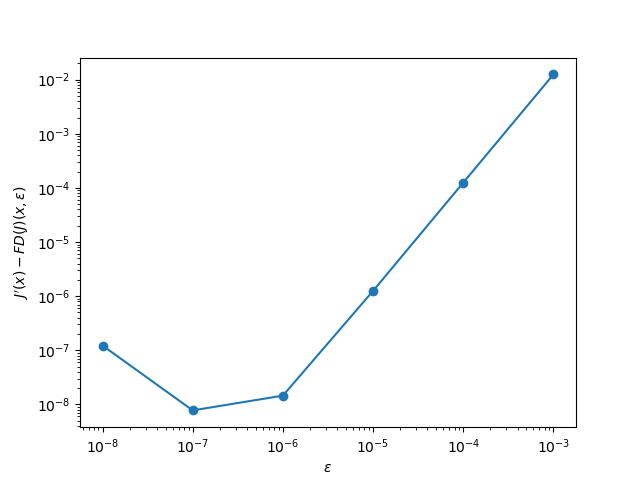

In [23]:
def f(x):
    Jxyarea.x = x
    return Jxyarea.J(), Jxyarea.dJ()

dofs = Jxyarea.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

### ProjectedCurveCurvedistance


In [24]:
Jccdist = ProjectedCurveCurveDistance( curves, cws, .1, projection='zphi' )

In [25]:
Jccdist.J()

Array(0.27301023, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

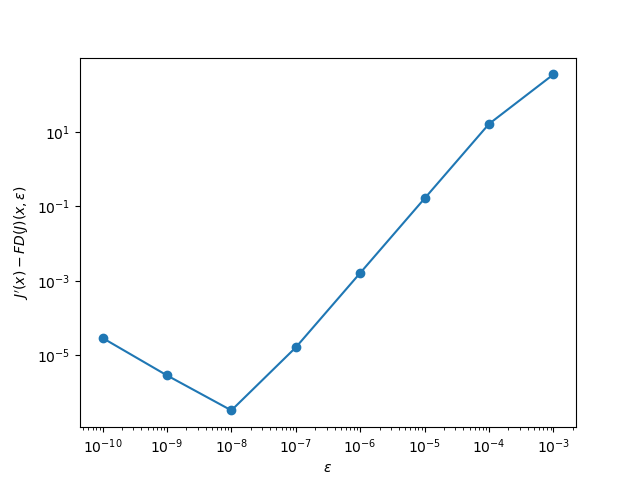

In [26]:
def f(x):
    Jccdist.x = x
    return Jccdist.J(), Jccdist.dJ()

dofs = Jccdist.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8,1e-9,1e-10]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

### Jconvex

In [27]:
Jdfp = DirectedFacingPort( cws, projection='r' )
Jdfp.J()

Array(2.93462385, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

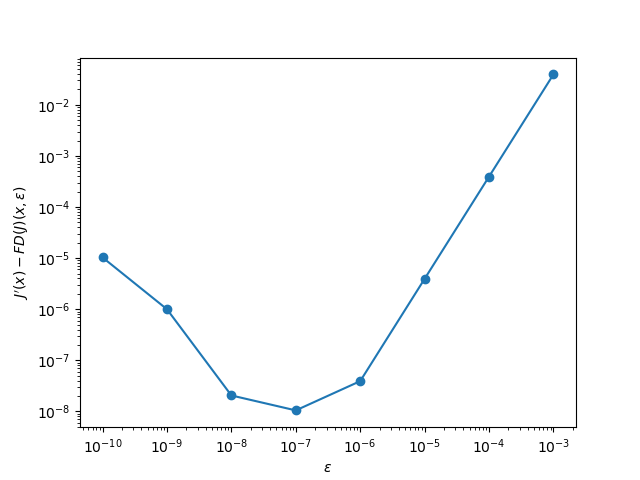

In [28]:
def f(x):
    Jdfp.x = x
    return Jdfp.J(), Jdfp.dJ()

dofs = Jdfp.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8,1e-9,1e-10]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")